# TiN TOPS heater from Femwell Examples

In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal import solve_thermal

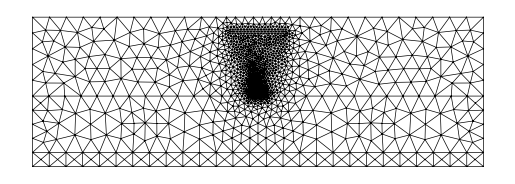

In [2]:
w_sim = 8 * 2
h_clad = 2.8
h_box = 2
w_core = 0.5
h_core = 0.22
h_heater = 0.14
w_heater = 2
offset_heater = 2 + (h_core + h_heater) / 2
h_silicon = 0.5

polygons = OrderedDict(
    bottom=LineString(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    wafer=Polygon(
        [
            (-w_sim / 2, -h_core / 2 - h_box - h_silicon),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box - h_silicon),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.04, "distance": 1},
    clad={"resolution": 0.6, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 1},
)

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()

 90%|█████████ | 9/10 [00:02<00:00,  4.40it/s]

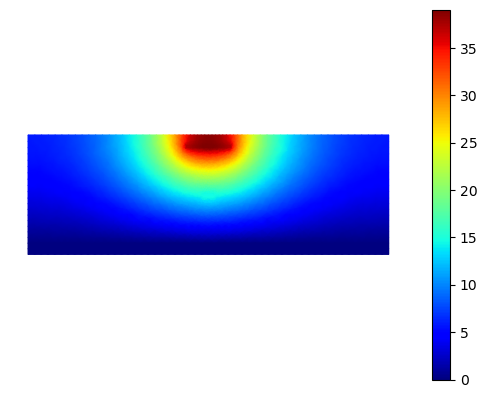

C:\Users\blow\AppData\Local\Temp\ipykernel_13956\3033154107.py:40: DeprecationWarning: The behavior of passing an array directly to `show` is deprecated and will be removed in the future. Use `plot` instead.
  modes[0].show(modes[0].E.real)


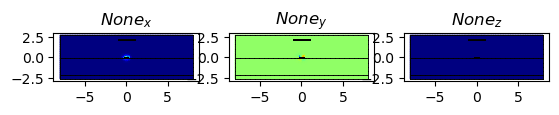

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


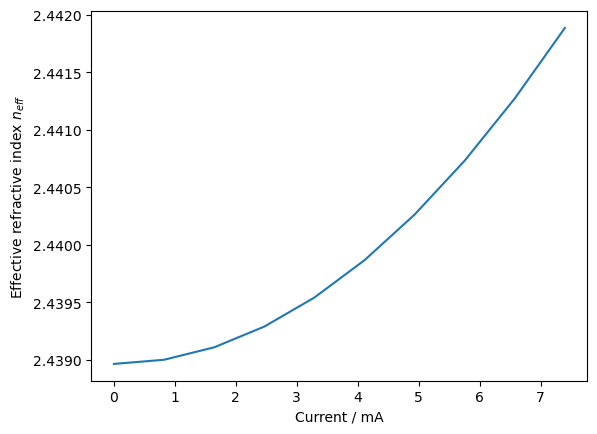

In [3]:
currents = np.linspace(0.0, 7.4e-3, 10)
current_densities = currents / polygons["heater"].area
neffs = []

for current_density in tqdm(current_densities):
    basis0 = Basis(mesh, ElementTriP0(), intorder=4)
    thermal_conductivity_p0 = basis0.zeros()
    for domain, value in {
        "core": 90,
        "box": 1.38,
        "clad": 1.38,
        "heater": 28,
        "wafer": 148,
    }.items():
        thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
    thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

    basis, temperature = solve_thermal(
        basis0,
        thermal_conductivity_p0,
        specific_conductivity={"heater": 2.3e6},
        current_densities={"heater": current_density},
        fixed_boundaries={"bottom": 0},
    )

    if current_density == current_densities[-1]:
        basis.plot(temperature, shading="gouraud", colorbar=True)
        plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2
    epsilon[basis0.get_dofs(elements="core")] = (
        3.4777 + 1.86e-4 * temperature0[basis0.get_dofs(elements="core")]
    ) ** 2
    # basis0.plot(epsilon, colorbar=True).show()

    modes = compute_modes(basis0, epsilon, wavelength=1.55, num_modes=1)

    if current_density == current_densities[-1]:
        modes[0].show(modes[0].E.real)

    neffs.append(np.real(modes[0].n_eff))

plt.xlabel("Current / mA")
plt.ylabel("Effective refractive index $n_{eff}$")
plt.plot(currents * 1e3, neffs)
plt.show()

In [4]:
print(f"Phase shift: {2 * np.pi / 1.55 * (neffs[-1] - neffs[0]) * 320}")

Phase shift: 3.7863216387925815


# Time Dynamics

In [8]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import scipy.constants
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0, LinearForm
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict
from femwell.thermal_transient import solve_thermal_transient

# Simulating the TiN TOPS heater in https://doi.org/10.1364/OE.27.010456


In [12]:
# !pip install mpi4py
# Errors in both :( 
# !pip install petsc4py
# !pip install petsc petsc4py

C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


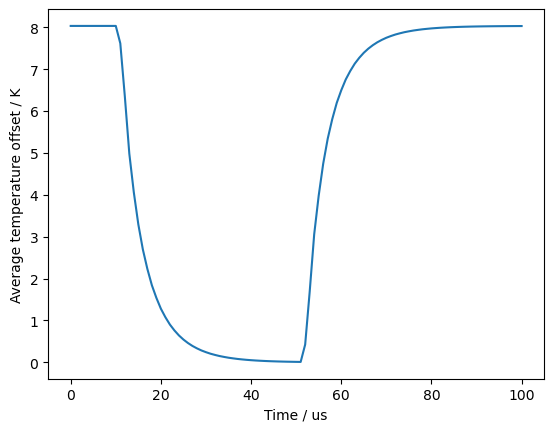

100%|██████████| 101/101 [00:32<00:00,  3.11it/s]


NameError: name 'modes_0' is not defined

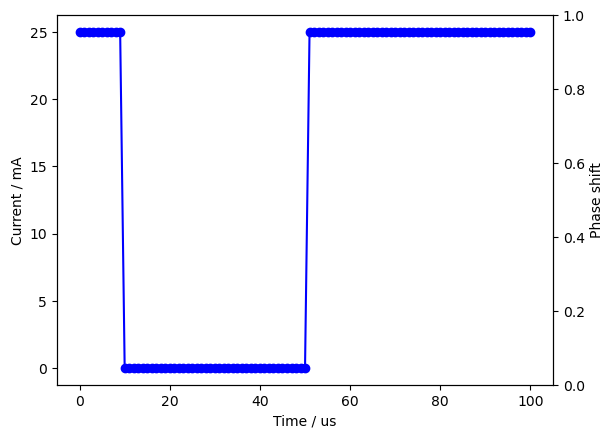

In [14]:
w_sim = 8 * 2
h_clad = 2.8
h_box = 1
w_core = 0.5
h_core = 0.22
offset_heater = 2.2
h_heater = 0.14
w_heater = 2
h_silicon = 3

wavelength = 1.55

polygons = OrderedDict(
    bottom=LineString([(-w_sim / 2, -h_box), (w_sim / 2, -h_box)]),
    core=Polygon(
        [
            (-w_core / 2, 0),
            (-w_core / 2, h_core),
            (w_core / 2, h_core),
            (w_core / 2, 0),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, offset_heater),
            (-w_heater / 2, offset_heater + h_heater),
            (w_heater / 2, offset_heater + h_heater),
            (w_heater / 2, offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, h_clad),
            (w_sim / 2, h_clad),
            (w_sim / 2, 0),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, 0),
            (-w_sim / 2, -h_box),
            (w_sim / 2, -h_box),
            (w_sim / 2, 0),
        ]
    ),
    # silicon=Polygon([
    #    (-w_sim / 2, - h_box - h_silicon),
    #    (-w_sim / 2, - h_box),
    #    (w_sim / 2, - h_box),
    #    (w_sim / 2, - h_box - h_silicon),
    # ]),
)

resolutions = dict(
    core={"resolution": 0.05, "distance": 1},
    clad={"resolution": 1, "distance": 1},
    box={"resolution": 1, "distance": 1},
    silicon={"resolution": 1, "distance": 1},
    heater={"resolution": 0.05, "distance": 1},
)

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.3))

basis0 = Basis(mesh, ElementTriP0(), intorder=4)
thermal_conductivity_p0 = basis0.zeros()
for domain, value in {
    "core": 148,
    "box": 1.38,
    "clad": 1.38,
    "heater": 28,
}.items():  # , 'silicon': 28
    thermal_conductivity_p0[basis0.get_dofs(elements=domain)] = value
thermal_conductivity_p0 *= 1e-12  # 1e-12 -> conversion from 1/m^2 -> 1/um^2

thermal_diffusivity_p0 = basis0.zeros()
for domain, value in {
    "heater": 28 / 598 / 5240,
    "box": 1.38 / 709 / 2203,
    "clad": 1.38 / 709 / 2203,
    "core": 148 / 711 / 2330,
    # "silicon": 148 / 711 / 2330,
}.items():
    thermal_diffusivity_p0[basis0.get_dofs(elements=domain)] = value
thermal_diffusivity_p0 *= 1e12  # 1e-12 -> conversion from m^2 -> um^2

dt = 0.1e-5
steps = 100


def current(t):
    return 0.007 / polygons["heater"].area * ((t < dt * steps / 10) + (t > dt * steps / 2))


basis, temperatures = solve_thermal_transient(
    basis0,
    thermal_conductivity_p0,
    thermal_diffusivity_p0,
    specific_conductivity={"heater": 2.3e6},
    current_densities_0={"heater": current(0)},
    current_densities={"heater": current},
    fixed_boundaries={"bottom": 0},
    dt=dt,
    steps=steps,
)


@LinearForm
def unit_load(v, w):
    return v


M = unit_load.assemble(basis.with_elements("core"))

times = np.array([dt * i for i in range(steps + 1)])
plt.xlabel("Time / us")
plt.ylabel("Average temperature offset / K")
plt.plot(times * 1e6, M @ np.array(temperatures).T / np.sum(M))
plt.show()

# for i in range(0, steps, 10):
#     fig, ax = plt.subplots(subplot_kw=dict(aspect=1))
#     for subdomain in mesh.subdomains.keys() - {'gmsh:bounding_entities'}:
#         mesh.restrict(subdomain).draw(ax=ax, boundaries_only=True)
#     basis.plot(temperatures[i], ax=ax, vmin=0, vmax=np.max(temperatures), shading='gouraud')
#     plt.show()

# Calculate modes

epsilon_0 = basis0.zeros() + 1.444**2
epsilon_0[basis0.get_dofs(elements="core")] = 3.4777**2
# modes_0 = compute_modes(basis0, epsilon_0, wavelength=wavelength, num_modes=1, solver="slepc")

neffs = []
neffs_approximated = []
for temperature in tqdm(temperatures):
    # basis.plot(temperature, vmin=0, vmax=np.max(temperatures))
    # plt.show()

    temperature0 = basis0.project(basis.interpolate(temperature))
    epsilon = basis0.zeros() + (1.444 + 1.00e-5 * temperature0) ** 2
    epsilon[basis0.get_dofs(elements="core")] = (
        3.4777 + 1.86e-4 * temperature0[basis0.get_dofs(elements="core")]
    ) ** 2
    # basis0.plot(epsilon, colorbar=True).show()

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=1)

    # from femwell.mode_solver import plot_mode
    # plot_mode(basis_modes, xs[0])
    # plt.show()

    neffs.append(np.real(modes[0].n_eff))
    # neffs_approximated.append(np.real(modes_0[0].calculate_pertubated_neff(epsilon - epsilon_0)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time / us")
ax.set_ylabel("Current / mA")
ax.plot(times * 1e6, current(times) * 1000, "b-o")
ax2 = ax.twinx()
ax2.set_ylabel("Phase shift")
ax2.plot(
    times * 1e6, 2 * np.pi / wavelength * (neffs - modes_0[0].n_eff) * 320, "r-o", label="Exact"
)
ax2.plot(
    times * 1e6,
    2 * np.pi / wavelength * (neffs_approximated - modes_0[0].n_eff) * 320,
    "g-o",
    label="Approximation",
)
plt.legend()
plt.show()